### set folder_name and day session to analyze

In [115]:
name = 'ANB2'
session = '20231030_d5'

### imports

In [11]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [116]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType, num_trials = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

For mac:

In [117]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANB2/analysis0_ANB2_20231030_d5/: File exists


For windows:

In [118]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANB2/analysis0_ANB2_20231030_d5/: File exists


preview trials

In [121]:
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(respMTX[0:10])

[[1.530391 2.170219 0.000000 nan -2.424030 0.000000 0.000000]
 [11.658425 12.386338 0.000000 nan -2.424030 0.000000 0.000000]
 [21.820022 22.554308 0.000000 nan -2.424030 0.000000 0.000000]
 [31.982171 32.447718 0.000000 nan -2.424030 0.000000 0.000000]
 [42.620223 43.159463 0.000000 nan -2.424030 0.000000 0.000000]
 [52.598383 53.128376 0.000000 nan -2.424030 0.000000 0.000000]
 [62.593388 63.304485 0.000000 nan -2.424030 0.000000 0.000000]
 [72.717161 73.362532 0.000000 nan -2.424030 0.000000 0.000000]
 [82.777459 83.383672 0.000000 nan -2.424030 0.000000 0.000000]
 [92.777484 93.112833 0.000000 nan -2.424030 0.000000 0.000000]]


### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [123]:
!./leverdata2binary {output_folder} {leverdata_matfile} 5000

lever_data from .mat size: 72000000,72000000
lever_data from .mat rank: 2
lever_data vector size: 72000000
lever_data vector with unused rows taken out size: 16282254
vector saved to .bin file ../Data_Copy/AnalysisData/ANB2/analysis0_ANB2_20231030_d5/full.bin
finished a trialITI: 63817 trialITI length: 58817 samples = ~9s
vector saved to .bin file ../Data_Copy/AnalysisData/ANB2/analysis0_ANB2_20231030_d5/trial0.bin
finished a trialITI: 123596 trialITI length: 59779 samples = ~10s
vector saved to .bin file ../Data_Copy/AnalysisData/ANB2/analysis0_ANB2_20231030_d5/trial1.bin
finished a trialITI: 183373 trialITI length: 59777 samples = ~10s
vector saved to .bin file ../Data_Copy/AnalysisData/ANB2/analysis0_ANB2_20231030_d5/trial2.bin
finished a trialITI: 245946 trialITI length: 62573 samples = ~10s
vector saved to .bin file ../Data_Copy/AnalysisData/ANB2/analysis0_ANB2_20231030_d5/trial3.bin
finished a trialITI: 304641 trialITI length: 58695 samples = ~9s
vector saved to .bin file ../Data

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [124]:
num_trials = 98

### Look at sampling rates for the `lever_data`

In [125]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  10.1280339
Number of lever_data samples:  58817
Estimated freq:  5807.346280703108
Trial  1
Duration in MATLAB seconds from respMTX:  10.161596500000002
Number of lever_data samples:  59779
Estimated freq:  5882.835438309324
Trial  2
Duration in MATLAB seconds from respMTX:  10.1621493
Number of lever_data samples:  59777
Estimated freq:  5882.3186154133755
Trial  3
Duration in MATLAB seconds from respMTX:  10.638052099999996
Number of lever_data samples:  62573
Estimated freq:  5881.997889444443
Trial  4
Duration in MATLAB seconds from respMTX:  9.978160100000004
Number of lever_data samples:  58695
Estimated freq:  5882.346986996127
Trial  5
Duration in MATLAB seconds from respMTX:  9.995004899999998
Number of lever_data samples:  58789
Estimated freq:  5881.838036917822
Trial  6
Duration in MATLAB seconds from respMTX:  10.123772700000004
Number of lever_data samples:  59550
Estimated freq:  5882.194490597362
Trial  7
Duration in MA

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 40 Hz

Assuming electrical noise will be around 60 Hz

In [128]:
butterworth_filter_leverdata(output_folder, num_trials)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [129]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [ ]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [ ]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

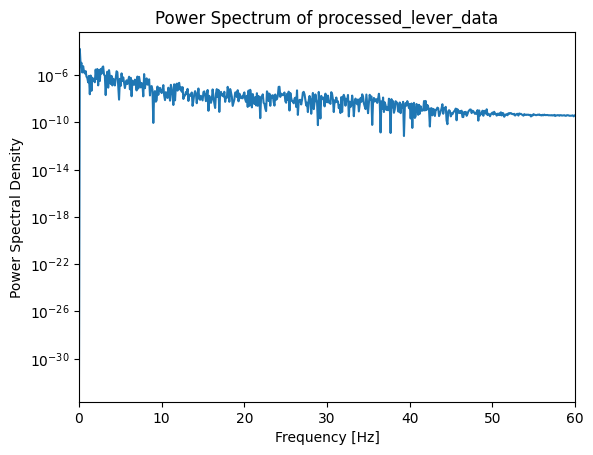

In [130]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)